In [1]:
import pandas as pd
from app import app, db, Reservation, DeviceStatus, User
from datetime import datetime, timedelta
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import re

import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('data\Sign up form for Esports room (Antwoorden) - Formulierreacties 1.csv')

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\samue\AppData\Local\Temp\ipykernel_118164\2635127739.py:1: SyntaxWarning: invalid escape sequence '\S'
  df1 = pd.read_csv('data\Sign up form for Esports room (Antwoorden) - Formulierreacties 1.csv')


In [3]:
df1 = df1.drop(['Time of visit', 'Date of visit ', 'Free space for comments', 'Which game are you going to play?', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12','Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'], axis=1)

In [4]:
# Rename columns to match SQLAlchemy model
df1.rename(columns={
    'Full name': 'name',
    'Which university are you from? (If not from a uni, please let us know from where at the "other" section)': 'school',
    'E-mailadres': 'email',
    'What PC/Console will you use?': 'device',
    'Tijdstempel': 'date'
}, inplace=True)

In [5]:
#df1.fillna('N/A')

In [6]:
df1

,date,name,Student number,device,school,email
0,19-9-2022 15:41:23,Jian Jin He,193099,NaN,NaN,NaN
1,19-9-2022 15:41:27,Thomas Pichardo,223834,NaN,NaN,NaN
2,19-9-2022 15:41:31,Samuel Antonio Vieira Vasconcelos,211941,NaN,NaN,NaN
3,19-9-2022 15:41:55,Juan José Gutierrez,215517,NaN,NaN,NaN
4,19-9-2022 15:42:07,Fedor Chursin,220905,NaN,NaN,NaN
...,...,...,...,...,...,...
2293,13-9-2024 11:01:38,Patyi Balazs,232737,08,Buas,patyi.balazs14@gmail.com
2294,13-9-2024 11:53:05,Sem Hooijmans,223121,02,Buas,semhooijmans@gmail.com
2295,13-9-2024 11:53:38,Rick van den Born,224264,01,Buas,224264@buas.nl
2296,13-9-2024 14:16:15,Laszlo Oliver,241565,05,Buas,oli.laszlo.21@gmail.com


# Pre Process Student Number Column

In [7]:
def process_student_number(number):
    if pd.isna(number):
        return 'N/A', 'N/A'
    
    # Remove any non-digit characters for processing
    cleaned_number = re.sub(r'\D', '', str(number))
    
    # Check if the cleaned number is exactly 6 digits
    if len(cleaned_number) == 6:
        return cleaned_number, 'N/A'
    else:
        # Check if the original number is a phone number
        if re.match(r'^\+|\d{10,}$', str(number)):
            return 'N/A', number
        else:
            return 'N/A', 'N/A'

In [8]:
# Apply the function to the dataframe
df1[['Student number', 'phone_number']] = df1['Student number'].apply(process_student_number).apply(pd.Series)

In [9]:
df1

,date,name,Student number,device,school,email,phone_number
0,19-9-2022 15:41:23,Jian Jin He,193099,NaN,NaN,NaN,N/A
1,19-9-2022 15:41:27,Thomas Pichardo,223834,NaN,NaN,NaN,N/A
2,19-9-2022 15:41:31,Samuel Antonio Vieira Vasconcelos,211941,NaN,NaN,NaN,N/A
3,19-9-2022 15:41:55,Juan José Gutierrez,215517,NaN,NaN,NaN,N/A
4,19-9-2022 15:42:07,Fedor Chursin,220905,NaN,NaN,NaN,N/A
...,...,...,...,...,...,...,...
2293,13-9-2024 11:01:38,Patyi Balazs,232737,08,Buas,patyi.balazs14@gmail.com,N/A
2294,13-9-2024 11:53:05,Sem Hooijmans,223121,02,Buas,semhooijmans@gmail.com,N/A
2295,13-9-2024 11:53:38,Rick van den Born,224264,01,Buas,224264@buas.nl,N/A
2296,13-9-2024 14:16:15,Laszlo Oliver,241565,05,Buas,oli.laszlo.21@gmail.com,N/A


In [10]:
# Create SQLAlchemy engine
engine = create_engine('sqlite:///instance/reservations.db')
Session = sessionmaker(bind=engine)
session = Session()

In [11]:
def map_df_to_model(df):
    reservations = []
    for index, row in df.iterrows():
        # Initialize date variable
        date = None
        
        if isinstance(row['date'], str):
            # Try parsing with different formats
            try:
                # Try with seconds
                date = datetime.strptime(row['date'], '%d-%m-%Y %H:%M:%S')
            except ValueError:
                try:
                    # Try without seconds
                    date = datetime.strptime(row['date'], '%d-%m-%Y %H:%M')
                except ValueError:
                    # Handle if neither format works
                    print(f"Failed to parse date: {row['date']}")
                    continue  # Skip this row if parsing fails
        else:
            # Convert Timestamp to datetime if it's not a string
            date = row['date'].to_pydatetime()

        # Create a Reservation instance
        reservation = Reservation(
            name=row['name'],
            school=row['school'] if pd.notna(row['school']) else 'Unknown',
            email=row['email'] if pd.notna(row['email']) else 'Unknown',
            device=row['device'] if pd.notna(row['device']) else 'Unknown',
            student_number=row['Student number'] if pd.notna(row['Student number']) else 'Unknown',
            pin_hash='N/A',
            date=date
        )
        reservations.append(reservation)
    
    return reservations


In [12]:
# Insert DataFrame data into the database
reservations = map_df_to_model(df1)

try:
    session.add_all(reservations)
    session.commit()
    print("Data inserted successfully.")
except Exception as e:
    session.rollback()
    print(f"An error occurred: {e}")
finally:
    session.close()

Data inserted successfully.


In [13]:
# Check current database entries
with app.app_context():
    # Query all reservations
    reservations = Reservation.query.all()
    print("Reservations:", reservations)

    # Query all device statuses
    device_statuses = DeviceStatus.query.all()
    print("Device Statuses:", device_statuses)

    # Query all users
    users = User.query.all()
    print("Users:", users)

    # Query reservations in the last 24 hours
    end_date = datetime.now()
    start_date = end_date - timedelta(days=1)
    reservations_last_24_hours = Reservation.query.filter(
        Reservation.date.between(start_date, end_date)
    ).all()
    print("Reservations in Last 24 Hours:", reservations_last_24_hours)

Reservations: [<Reservation 1 | Student Number: 193099 | Name: Jian Jin He | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:41:23>, <Reservation 2 | Student Number: 223834 | Name: Thomas Pichardo | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:41:27>, <Reservation 3 | Student Number: 211941 | Name: Samuel Antonio Vieira Vasconcelos | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:41:31>, <Reservation 4 | Student Number: 215517 | Name: Juan José Gutierrez | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:41:55>, <Reservation 5 | Student Number: 220905 | Name: Fedor Chursin | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:42:07>, <Reservation 6 | Student Number: 191019 | Name: Thijs Massink | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 16:10:50>, <Reservation 7 | Student Number: 215434 | Name: Danyel Fijten | School: Unknown | Email: 

# Bar Chart -> Average Hive visitors per day of the week

In [14]:
df1['date'] = pd.to_datetime(df1['date'], format="%d-%m-%Y %H:%M:%S", errors='coerce', dayfirst=True)


In [ ]:
# Step 2: Extract day of the week and year
df1['day_of_week'] = df1['date'].dt.day_name()
df1['year'] = df1['date'].dt.year

# Step 3: Group by year and day of the week, and count entries
average_entries = df1.groupby(['year', 'day_of_week']).size().reset_index(name='entries')


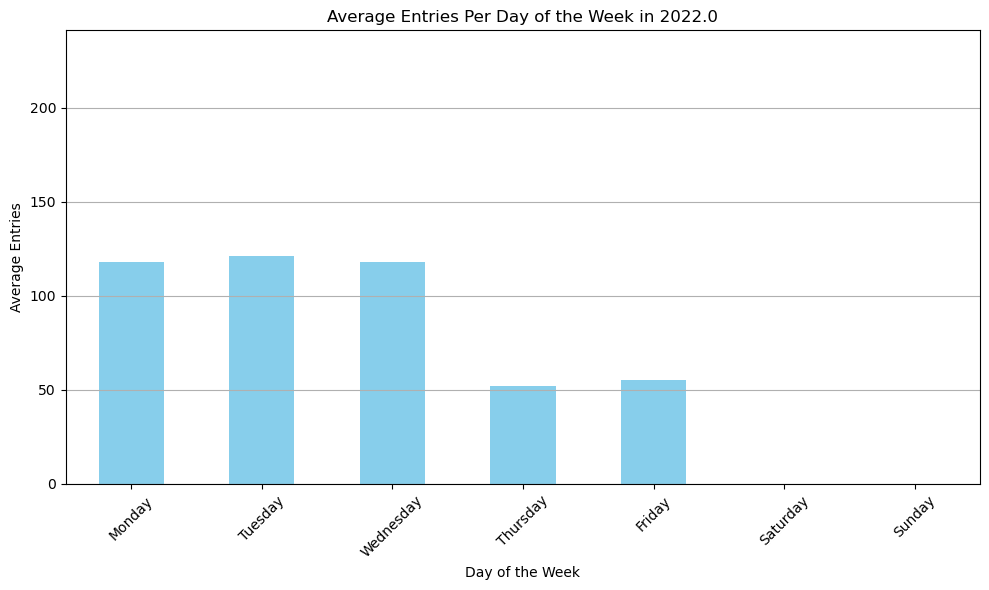

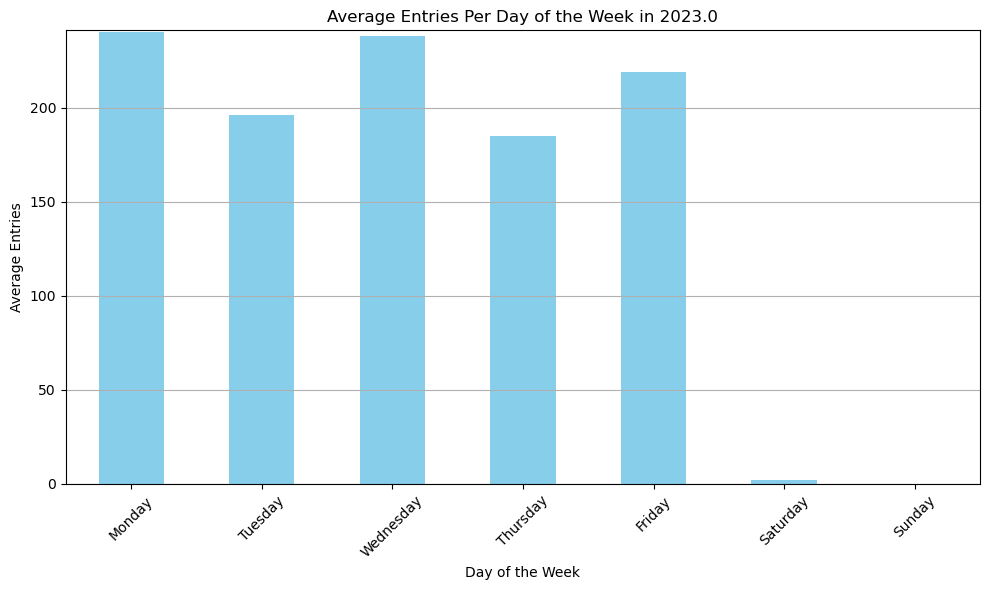

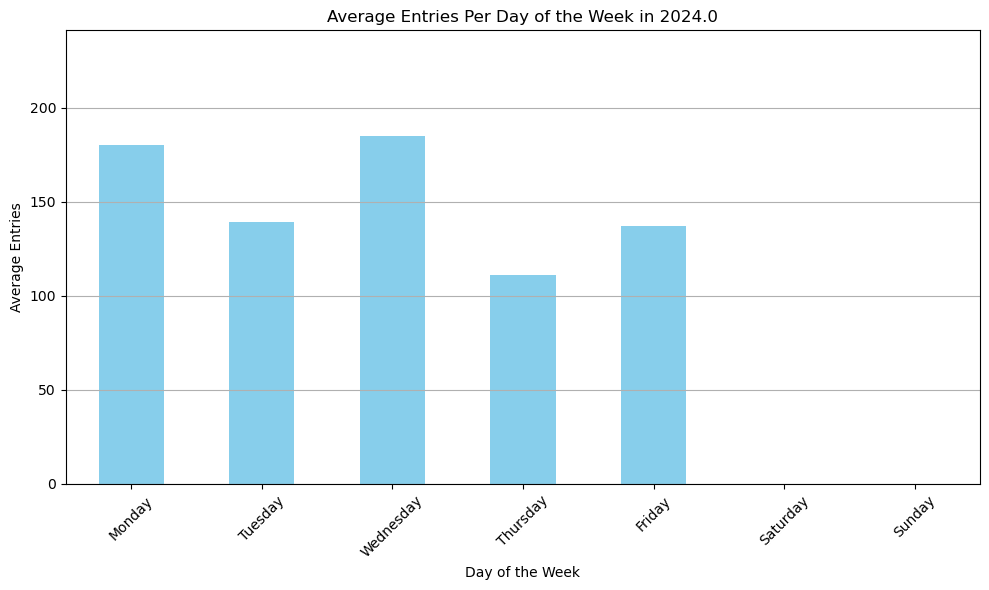

In [19]:
# Step 4: Calculate average entries per day of the week for each year
average_per_weekday = average_entries.groupby(['year', 'day_of_week'])['entries'].mean().unstack()

# Step 5: Define the order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Ensure the index is ordered
average_per_weekday = average_per_weekday.reindex(columns=weekday_order)

# Step 6: Determine the global maximum value for the y-axis
global_max = average_per_weekday.max().max()

# Step 7: Plotting separate bar charts for each year with a common scale
for year in average_per_weekday.index:
    plt.figure(figsize=(10, 6))
    average_per_weekday.loc[year].plot(kind='bar', color='skyblue')
    plt.title(f'Average Entries Per Day of the Week in {year}')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Entries')
    plt.xticks(rotation=45)
    plt.ylim(0, global_max + 1)  # Set the y-axis limit
    plt.grid(axis='y')
    plt.tight_layout()  # Adjust layout to fit titles and labels
    plt.show()

# Bar Chart -> Average Hive visitors per month

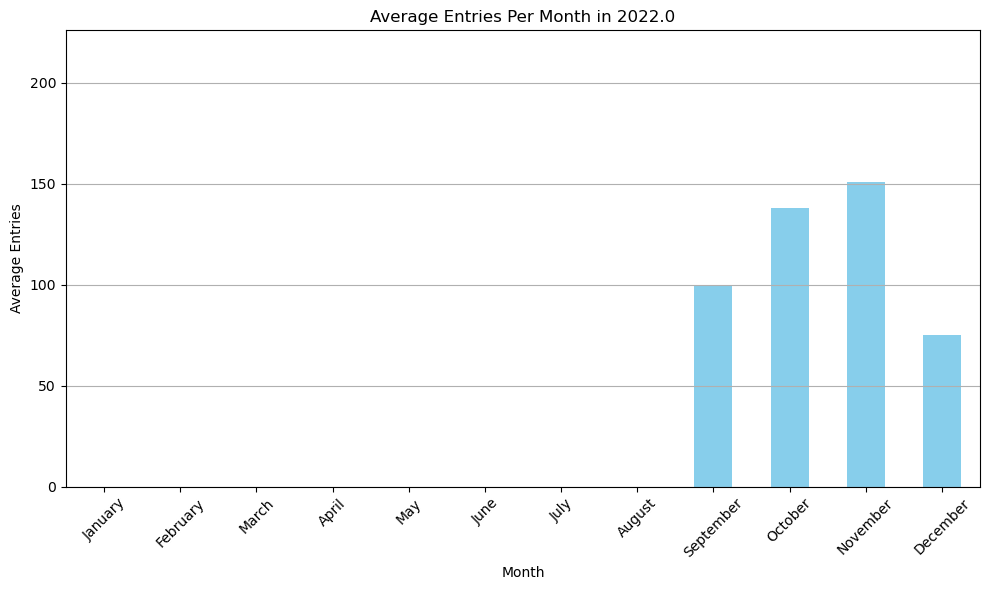

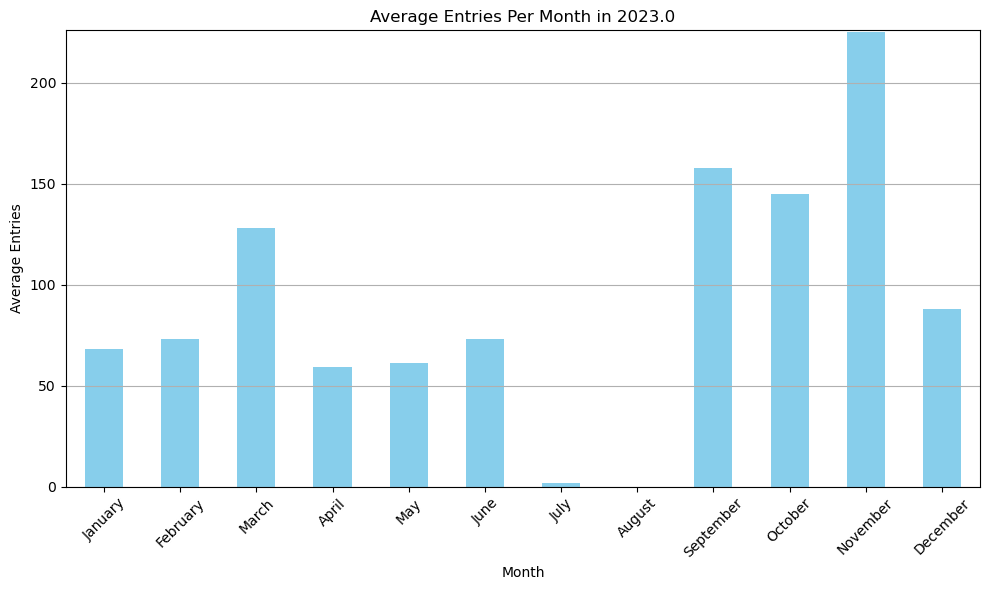

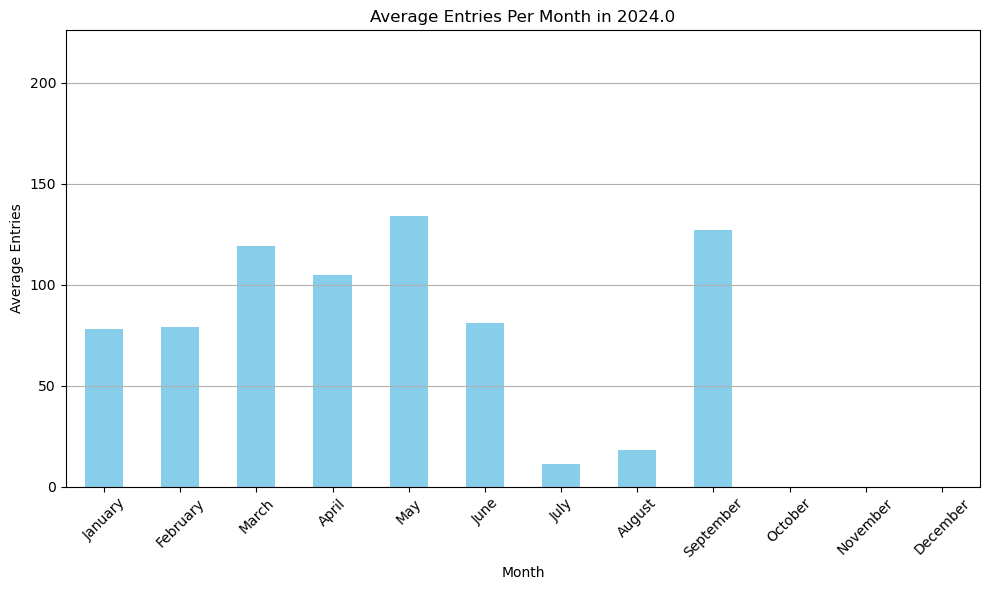

In [23]:
# Step 2: Extract month and year
df1['month'] = df1['date'].dt.month_name()  # Get month name
df1['year'] = df1['date'].dt.year

# Step 3: Group by year and month, and count entries
average_entries = df1.groupby(['year', 'month']).size().reset_index(name='entries')

# Step 4: Calculate average entries per month for each year
average_per_month = average_entries.groupby(['year', 'month'])['entries'].mean().unstack()

# Step 5: Define the order of months
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Ensure the index is ordered
average_per_month = average_per_month.reindex(columns=month_order)

# Step 6: Determine the global maximum value for the y-axis
global_max = average_per_month.max().max()

# Step 7: Plotting separate bar charts for each year with a common scale
for year in average_per_month.index:
    plt.figure(figsize=(10, 6))
    average_per_month.loc[year].plot(kind='bar', color='skyblue')
    plt.title(f'Average Entries Per Month in {year}')
    plt.xlabel('Month')
    plt.ylabel('Average Entries')
    plt.xticks(rotation=45)
    plt.ylim(0, global_max + 1)  # Set the y-axis limit
    plt.grid(axis='y')
    plt.tight_layout()  # Adjust layout to fit titles and labels
    plt.show()